In [1]:

# IRT Fault Detection Using Transfer Learning with VGG-16

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pandas as pd
import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import time
from tensorflow.keras.models import load_model
import time
import random

In [2]:
# --- Setup ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 70

In [3]:
# --- Organize Dataset ---
original_data_dir = '/Users/reamy/Desktop/THESIS/BC_dataset'  # Contains 'faulty/' and 'non_faulty/' folders
base_dir = 'data/processed'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create directories
for split in ['train', 'val']:
    for cls in ['faulty', 'non-faulty']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Split and copy images
for cls in ['faulty', 'non-faulty']:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_images:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

In [4]:
# --- Data Augmentation and Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 182 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [5]:
# --- Get True Labels for Callback ---
val_labels = np.concatenate([val_generator[i][1] for i in range(len(val_generator))])

# --- Load VGG16 base model (without top) ---
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# --- Add custom classification head ---
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
# --- Compile Model ---
model.compile(
    optimizer='adamW',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)
model.summary()

# Save model summary to file
summary_file_path = os.path.join(os.getcwd(), 'vgg16_model_summary.txt')
with io.StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + '\n'))
    summary_text = buf.getvalue()

with open(summary_file_path, 'w') as f:
    f.write(summary_text)

print(f"Model summary saved to {summary_file_path}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model summary saved to /Users/reamy/Desktop/THESIS/VGG-16_BC/vgg16_model_summary.txt


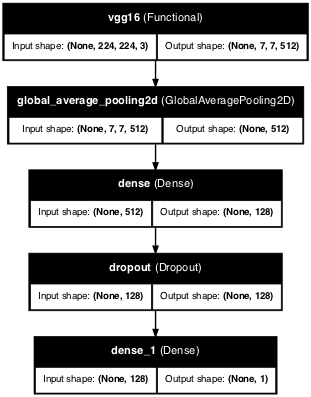

In [7]:
# Save the architecture as an image file in the current working directory
output_path = os.path.join(os.getcwd(), 'vgg16_model_architecture.png')
plot_model(model, to_file=output_path, show_shapes=True, show_layer_names=True, dpi=50)

# Display the architecture in the notebook
Image(filename=output_path)

In [8]:
# --- Custom Callback to Track Metrics ---
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, val_labels):
        self.val_generator = val_generator
        self.val_labels = val_labels.reshape(-1).astype(int)
        self.results = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = model.predict(self.val_generator)
        val_predictions = (val_predictions > 0.5).astype(int).reshape(-1)

        precision = precision_score(self.val_labels, val_predictions)
        recall = recall_score(self.val_labels, val_predictions)
        f1 = f1_score(self.val_labels, val_predictions)

        self.results.append({
            'Epoch': epoch + 1,
            'Training Accuracy': logs['accuracy'],
            'Validation Accuracy': logs['val_accuracy'],
            'Training Loss': logs['loss'],
            'Validation Loss': logs['val_loss'],
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })

        print(f"Epoch {epoch + 1}: Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

metrics_callback = MetricsCallback(val_generator, val_labels)

In [9]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

# Save the best model only
checkpoint = ModelCheckpoint(
    filepath='best_VGG16_BC_model.h5',          # file to save the best model
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # save only if it's the best so far
    mode='min',                        # because we want to minimize loss
    verbose=1                          # print when saving
)

In [10]:
# start timer
start_time = time.time()
# --- Train the Model ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[metrics_callback,early_stop,checkpoint]
)
# End timer
end_time = time.time()
# Calculate and print elapsed time
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes).")

/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5059 - auc: 0.5171 - loss: 0.7906 - precision: 0.4780 - recall: 0.23
Epoch 1: Precision=0.5000, Recall=1.0000, F1 Score=0.6667

Epoch 1: val_loss improved from inf to 0.71552, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5050 - auc: 0.5191 - loss: 0.7863 - precision: 0.4812 - recall: 0.2658 - val_accuracy: 0.5000 - val_auc: 0.6749 - val_loss: 0.7155 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5518 - auc: 0.5966 - loss: 0.7328 - precision: 0.5280 - recall: 0.82
Epoch 2: Precision=1.0000, Recall=0.2174, F1 Score=0.3571

Epoch 2: val_loss improved from 0.71552 to 0.67887, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5538 - auc: 0.5950 - loss: 0.7321 - precision: 0.5307 - recall: 0.8209 - val_accuracy: 0.6087 - val_auc: 0.8327 - val_loss: 0.6789 - val_precision: 1.0000 - val_recall: 0.2174
Epoch 3/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4874 - auc: 0.4674 - loss: 0.7628 - precision: 0.4891 - recall: 0.51
Epoch 3: Precision=0.0000, Recall=0.0000, F1 Score=0.0000

Epoch 3: val_loss improved from 0.67887 to 0.67408, saving model to best_VGG16_BC_model.h5


/Users/reamy/Desktop/THESIS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.4947 - auc: 0.4793 - loss: 0.7562 - precision: 0.4967 - recall: 0.5085 - val_accuracy: 0.5000 - val_auc: 0.8875 - val_loss: 0.6741 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5123 - auc: 0.5268 - loss: 0.7242 - precision: 0.5023 - recall: 0.40
Epoch 4: Precision=0.9444, Recall=0.7391, F1 Score=0.8293

Epoch 4: val_loss improved from 0.67408 to 0.66055, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.5137 - auc: 0.5308 - loss: 0.7230 - precision: 0.5061 - recall: 0.4071 - val_accuracy: 0.8478 - val_auc: 0.9159 - val_loss: 0.6606 - val_precision: 0.9444 - val_recall: 0.7391
Epoch 5/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6145 - auc: 0.6214 - loss: 0.6748 - precision: 0.6216 - recall: 0.64
Epoch 5: Precision=0.5610, Recall=1.0000, F1 Score=0.7188

Epoch 5: val_loss improved from 0.66055 to 0.65364, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.6107 - auc: 0.6203 - loss: 0.6750 - precision: 0.6154 - recall: 0.6490 - val_accuracy: 0.6087 - val_auc: 0.9149 - val_loss: 0.6536 - val_precision: 0.5610 - val_recall: 1.0000
Epoch 6/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6139 - auc: 0.6895 - loss: 0.6471 - precision: 0.5955 - recall: 0.77
Epoch 6: Precision=0.7333, Recall=0.9565, F1 Score=0.8302

Epoch 6: val_loss improved from 0.65364 to 0.64417, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.6133 - auc: 0.6883 - loss: 0.6479 - precision: 0.5935 - recall: 0.7800 - val_accuracy: 0.8043 - val_auc: 0.9263 - val_loss: 0.6442 - val_precision: 0.7333 - val_recall: 0.9565
Epoch 7/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5824 - auc: 0.6352 - loss: 0.6575 - precision: 0.5728 - recall: 0.67
Epoch 7: Precision=0.9167, Recall=0.4783, F1 Score=0.6286

Epoch 7: val_loss improved from 0.64417 to 0.63835, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.5824 - auc: 0.6343 - loss: 0.6584 - precision: 0.5726 - recall: 0.6731 - val_accuracy: 0.7174 - val_auc: 0.9168 - val_loss: 0.6384 - val_precision: 0.9167 - val_recall: 0.4783
Epoch 8/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6181 - auc: 0.7021 - loss: 0.6332 - precision: 0.6139 - recall: 0.62
Epoch 8: Precision=0.9000, Recall=0.3913, F1 Score=0.5455

Epoch 8: val_loss improved from 0.63835 to 0.63157, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.6122 - auc: 0.6963 - loss: 0.6361 - precision: 0.6098 - recall: 0.6145 - val_accuracy: 0.6739 - val_auc: 0.9130 - val_loss: 0.6316 - val_precision: 0.9000 - val_recall: 0.3913
Epoch 9/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6183 - auc: 0.6445 - loss: 0.6548 - precision: 0.5939 - recall: 0.52
Epoch 9: Precision=0.9412, Recall=0.6957, F1 Score=0.8000

Epoch 9: val_loss improved from 0.63157 to 0.62111, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.6202 - auc: 0.6482 - loss: 0.6542 - precision: 0.6004 - recall: 0.5378 - val_accuracy: 0.8261 - val_auc: 0.9140 - val_loss: 0.6211 - val_precision: 0.9412 - val_recall: 0.6957
Epoch 10/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7040 - auc: 0.7770 - loss: 0.6043 - precision: 0.6640 - recall: 0.75
Epoch 10: Precision=0.8182, Recall=0.7826, F1 Score=0.8000

Epoch 10: val_loss improved from 0.62111 to 0.61053, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.7039 - auc: 0.7746 - loss: 0.6056 - precision: 0.6672 - recall: 0.7530 - val_accuracy: 0.8043 - val_auc: 0.9168 - val_loss: 0.6105 - val_precision: 0.8182 - val_recall: 0.7826
Epoch 11/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6388 - auc: 0.6949 - loss: 0.6298 - precision: 0.6151 - recall: 0.76
Epoch 11: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 11: val_loss improved from 0.61053 to 0.60625, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.6425 - auc: 0.6992 - loss: 0.6282 - precision: 0.6185 - recall: 0.7681 - val_accuracy: 0.8696 - val_auc: 0.9149 - val_loss: 0.6063 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 12/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7200 - auc: 0.7548 - loss: 0.6101 - precision: 0.7039 - recall: 0.78
Epoch 12: Precision=0.9333, Recall=0.6087, F1 Score=0.7368

Epoch 12: val_loss improved from 0.60625 to 0.60233, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.7161 - auc: 0.7509 - loss: 0.6119 - precision: 0.7001 - recall: 0.7789 - val_accuracy: 0.7826 - val_auc: 0.9159 - val_loss: 0.6023 - val_precision: 0.9333 - val_recall: 0.6087
Epoch 13/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6439 - auc: 0.7067 - loss: 0.6335 - precision: 0.6216 - recall: 0.58
Epoch 13: Precision=0.9091, Recall=0.4348, F1 Score=0.5882

Epoch 13: val_loss improved from 0.60233 to 0.59783, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.6484 - auc: 0.7140 - loss: 0.6312 - precision: 0.6328 - recall: 0.5863 - val_accuracy: 0.6957 - val_auc: 0.9168 - val_loss: 0.5978 - val_precision: 0.9091 - val_recall: 0.4348
Epoch 14/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7182 - auc: 0.8011 - loss: 0.5953 - precision: 0.7352 - recall: 0.68
Epoch 14: Precision=0.9000, Recall=0.7826, F1 Score=0.8372

Epoch 14: val_loss improved from 0.59783 to 0.58064, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7161 - auc: 0.7962 - loss: 0.5972 - precision: 0.7300 - recall: 0.6894 - val_accuracy: 0.8478 - val_auc: 0.9178 - val_loss: 0.5806 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 15/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8020 - auc: 0.8292 - loss: 0.5752 - precision: 0.7676 - recall: 0.91
Epoch 15: Precision=0.8571, Recall=0.7826, F1 Score=0.8182

Epoch 15: val_loss improved from 0.58064 to 0.57212, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7950 - auc: 0.8266 - loss: 0.5766 - precision: 0.7568 - recall: 0.9152 - val_accuracy: 0.8261 - val_auc: 0.9187 - val_loss: 0.5721 - val_precision: 0.8571 - val_recall: 0.7826
Epoch 16/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7292 - auc: 0.8155 - loss: 0.5815 - precision: 0.7021 - recall: 0.79
Epoch 16: Precision=0.8889, Recall=0.3478, F1 Score=0.5000

Epoch 16: val_loss did not improve from 0.57212
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7294 - auc: 0.8125 - loss: 0.5829 - precision: 0.7066 - recall: 0.7815 - val_accuracy: 0.6522 - val_auc: 0.9149 - val_loss: 0.5834 - val_precision: 0.8889 - val_recall: 0.3478
Epoch 17/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7064 - auc: 0.8306 - loss: 0.5815 - precision: 0.7446 - recall: 0.60
Epoch 17: Precision=0.9000, Recall=0.7826, F1 Score=0.8372

Epoch 17: val_loss improved from 0.57212 to 0.55910, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7028 - auc: 0.8267 - loss: 0.5826 - precision: 0.7388 - recall: 0.6096 - val_accuracy: 0.8478 - val_auc: 0.9206 - val_loss: 0.5591 - val_precision: 0.9000 - val_recall: 0.7826
Epoch 18/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7645 - auc: 0.8277 - loss: 0.5661 - precision: 0.7172 - recall: 0.85
Epoch 18: Precision=0.8636, Recall=0.8261, F1 Score=0.8444

Epoch 18: val_loss improved from 0.55910 to 0.54928, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.7597 - auc: 0.8268 - loss: 0.5667 - precision: 0.7145 - recall: 0.8449 - val_accuracy: 0.8478 - val_auc: 0.9197 - val_loss: 0.5493 - val_precision: 0.8636 - val_recall: 0.8261
Epoch 19/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7905 - auc: 0.8621 - loss: 0.5472 - precision: 0.7536 - recall: 0.82
Epoch 19: Precision=0.9167, Recall=0.4783, F1 Score=0.6286

Epoch 19: val_loss did not improve from 0.54928
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.7874 - auc: 0.8616 - loss: 0.5475 - precision: 0.7527 - recall: 0.8273 - val_accuracy: 0.7174 - val_auc: 0.9187 - val_loss: 0.5598 - val_precision: 0.9167 - val_recall: 0.4783
Epoch 20/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8196 - auc: 0.8846 - loss: 0.5236 - precision: 0.8517 - recall: 0.80
Epoch 20: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 20: val_loss improved from 0.54928 to 0.54153, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8163 - auc: 0.8798 - loss: 0.5261 - precision: 0.8417 - recall: 0.8096 - val_accuracy: 0.8696 - val_auc: 0.9187 - val_loss: 0.5415 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 21/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8188 - auc: 0.8950 - loss: 0.5045 - precision: 0.8043 - recall: 0.85
Epoch 21: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 21: val_loss improved from 0.54153 to 0.53510, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8172 - auc: 0.8930 - loss: 0.5057 - precision: 0.8017 - recall: 0.8532 - val_accuracy: 0.8696 - val_auc: 0.9216 - val_loss: 0.5351 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 22/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8016 - auc: 0.8722 - loss: 0.5396 - precision: 0.7550 - recall: 0.88
Epoch 22: Precision=0.9286, Recall=0.5652, F1 Score=0.7027

Epoch 22: val_loss did not improve from 0.53510
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7970 - auc: 0.8668 - loss: 0.5404 - precision: 0.7554 - recall: 0.8690 - val_accuracy: 0.7609 - val_auc: 0.9197 - val_loss: 0.5383 - val_precision: 0.9286 - val_recall: 0.5652
Epoch 23/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7512 - auc: 0.8632 - loss: 0.5193 - precision: 0.7962 - recall: 0.65
Epoch 23: Precision=0.8636, Recall=0.8261, F1 Score=0.8444

Epoch 23: val_loss improved from 0.53510 to 0.51127, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7483 - auc: 0.8592 - loss: 0.5213 - precision: 0.7905 - recall: 0.6592 - val_accuracy: 0.8478 - val_auc: 0.9225 - val_loss: 0.5113 - val_precision: 0.8636 - val_recall: 0.8261
Epoch 24/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6959 - auc: 0.7990 - loss: 0.5663 - precision: 0.6481 - recall: 0.78
Epoch 24: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 24: val_loss did not improve from 0.51127
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7040 - auc: 0.8059 - loss: 0.5613 - precision: 0.6580 - recall: 0.7920 - val_accuracy: 0.8696 - val_auc: 0.9225 - val_loss: 0.5196 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 25/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7802 - auc: 0.8203 - loss: 0.5465 - precision: 0.7824 - recall: 0.80
Epoch 25: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 25: val_loss did not improve from 0.51127
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7794 - auc: 0.821

6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.7934 - auc: 0.8444 - loss: 0.5245 - precision: 0.7612 - recall: 0.8448 - val_accuracy: 0.8696 - val_auc: 0.9244 - val_loss: 0.5052 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 27/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8326 - auc: 0.9231 - loss: 0.4813 - precision: 0.8081 - recall: 0.88
Epoch 27: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 27: val_loss improved from 0.50516 to 0.49867, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.8314 - auc: 0.9209 - loss: 0.4820 - precision: 0.8085 - recall: 0.8771 - val_accuracy: 0.8696 - val_auc: 0.9253 - val_loss: 0.4987 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 28/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7671 - auc: 0.8524 - loss: 0.5154 - precision: 0.7619 - recall: 0.76
Epoch 28: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 28: val_loss improved from 0.49867 to 0.48700, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7674 - auc: 0.8525 - loss: 0.5156 - precision: 0.7598 - recall: 0.7752 - val_accuracy: 0.8696 - val_auc: 0.9301 - val_loss: 0.4870 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 29/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8183 - auc: 0.8866 - loss: 0.5005 - precision: 0.7725 - recall: 0.90
Epoch 29: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 29: val_loss improved from 0.48700 to 0.47652, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8183 - auc: 0.8883 - loss: 0.4966 - precision: 0.7742 - recall: 0.8991 - val_accuracy: 0.8696 - val_auc: 0.9319 - val_loss: 0.4765 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 30/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8309 - auc: 0.8913 - loss: 0.4583 - precision: 0.7952 - recall: 0.90
Epoch 30: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 30: val_loss did not improve from 0.47652
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8237 - auc: 0.8870 - loss: 0.4646 - precision: 0.7884 - recall: 0.8944 - val_accuracy: 0.8696 - val_auc: 0.9338 - val_loss: 0.4773 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 31/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7775 - auc: 0.8667 - loss: 0.4987 - precision: 0.7833 - recall: 0.74
Epoch 31: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 31: val_loss did not improve from 0.47652
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7802 - auc: 0.867

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8115 - auc: 0.8593 - loss: 0.5041 - precision: 0.7922 - recall: 0.8481 - val_accuracy: 0.8913 - val_auc: 0.9376 - val_loss: 0.4574 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 33/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8058 - auc: 0.9044 - loss: 0.4646 - precision: 0.7569 - recall: 0.86
Epoch 33: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 33: val_loss improved from 0.45743 to 0.45582, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8100 - auc: 0.9049 - loss: 0.4634 - precision: 0.7625 - recall: 0.8674 - val_accuracy: 0.8696 - val_auc: 0.9386 - val_loss: 0.4558 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 34/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7617 - auc: 0.8581 - loss: 0.4952 - precision: 0.7423 - recall: 0.77
Epoch 34: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 34: val_loss improved from 0.45582 to 0.45405, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.7643 - auc: 0.8593 - loss: 0.4947 - precision: 0.7469 - recall: 0.7766 - val_accuracy: 0.8696 - val_auc: 0.9395 - val_loss: 0.4541 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 35/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8588 - auc: 0.9120 - loss: 0.4326 - precision: 0.8405 - recall: 0.90
Epoch 35: Precision=0.9048, Recall=0.8261, F1 Score=0.8636

Epoch 35: val_loss improved from 0.45405 to 0.43292, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8554 - auc: 0.9110 - loss: 0.4345 - precision: 0.8350 - recall: 0.8993 - val_accuracy: 0.8696 - val_auc: 0.9395 - val_loss: 0.4329 - val_precision: 0.9048 - val_recall: 0.8261
Epoch 36/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7850 - auc: 0.8906 - loss: 0.4605 - precision: 0.7387 - recall: 0.88
Epoch 36: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 36: val_loss did not improve from 0.43292
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7859 - auc: 0.8893 - loss: 0.4613 - precision: 0.7400 - recall: 0.8814 - val_accuracy: 0.8696 - val_auc: 0.9405 - val_loss: 0.4527 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 37/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7980 - auc: 0.9071 - loss: 0.4573 - precision: 0.7866 - recall: 0.81
Epoch 37: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 37: val_loss did not improve from 0.43292
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7962 - auc: 0.904

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8139 - auc: 0.9016 - loss: 0.4584 - precision: 0.8023 - recall: 0.8212 - val_accuracy: 0.8913 - val_auc: 0.9423 - val_loss: 0.4258 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 39/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8039 - auc: 0.8844 - loss: 0.4616 - precision: 0.7784 - recall: 0.88
Epoch 39: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 39: val_loss did not improve from 0.42584
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.8029 - auc: 0.8852 - loss: 0.4621 - precision: 0.7737 - recall: 0.8869 - val_accuracy: 0.8696 - val_auc: 0.9414 - val_loss: 0.4344 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 40/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8141 - auc: 0.9135 - loss: 0.4286 - precision: 0.8588 - recall: 0.78
Epoch 40: Precision=0.9333, Recall=0.6087, F1 Score=0.7368

Epoch 40: val_loss did not improve from 0.42584
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.8171 - auc: 0.913

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8574 - auc: 0.9464 - loss: 0.4060 - precision: 0.9206 - recall: 0.7906 - val_accuracy: 0.8913 - val_auc: 0.9433 - val_loss: 0.4058 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 42/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7920 - auc: 0.8834 - loss: 0.4697 - precision: 0.7409 - recall: 0.90
Epoch 42: Precision=0.9048, Recall=0.8261, F1 Score=0.8636

Epoch 42: val_loss improved from 0.40576 to 0.39968, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.7927 - auc: 0.8831 - loss: 0.4684 - precision: 0.7415 - recall: 0.9063 - val_accuracy: 0.8696 - val_auc: 0.9452 - val_loss: 0.3997 - val_precision: 0.9048 - val_recall: 0.8261
Epoch 43/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8360 - auc: 0.9487 - loss: 0.3998 - precision: 0.7698 - recall: 0.92
Epoch 43: Precision=0.9474, Recall=0.7826, F1 Score=0.8571

Epoch 43: val_loss did not improve from 0.39968
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8327 - auc: 0.9426 - loss: 0.4060 - precision: 0.7701 - recall: 0.9232 - val_accuracy: 0.8696 - val_auc: 0.9471 - val_loss: 0.4227 - val_precision: 0.9474 - val_recall: 0.7826
Epoch 44/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8787 - auc: 0.9293 - loss: 0.3943 - precision: 0.8681 - recall: 0.89
Epoch 44: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 44: val_loss improved from 0.39968 to 0.39784, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.8732 - auc: 0.9258 - loss: 0.3991 - precision: 0.8637 - recall: 0.8839 - val_accuracy: 0.8913 - val_auc: 0.9509 - val_loss: 0.3978 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 45/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7996 - auc: 0.9082 - loss: 0.4307 - precision: 0.7165 - recall: 0.88
Epoch 45: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 45: val_loss did not improve from 0.39784
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8024 - auc: 0.9084 - loss: 0.4311 - precision: 0.7247 - recall: 0.8861 - val_accuracy: 0.8913 - val_auc: 0.9518 - val_loss: 0.3987 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 46/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8210 - auc: 0.9199 - loss: 0.4159 - precision: 0.7714 - recall: 0.88
Epoch 46: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 46: val_loss improved from 0.39784 to 0.39174, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.8168 - auc: 0.9148 - loss: 0.4205 - precision: 0.7717 - recall: 0.8804 - val_accuracy: 0.8913 - val_auc: 0.9518 - val_loss: 0.3917 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 47/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8609 - auc: 0.9536 - loss: 0.3932 - precision: 0.8239 - recall: 0.89
Epoch 47: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 47: val_loss improved from 0.39174 to 0.38937, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8620 - auc: 0.9530 - loss: 0.3930 - precision: 0.8270 - recall: 0.8987 - val_accuracy: 0.8913 - val_auc: 0.9518 - val_loss: 0.3894 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 48/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8720 - auc: 0.9312 - loss: 0.4200 - precision: 0.8777 - recall: 0.87
Epoch 48: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 48: val_loss improved from 0.38937 to 0.37906, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8738 - auc: 0.9326 - loss: 0.4169 - precision: 0.8747 - recall: 0.8855 - val_accuracy: 0.8913 - val_auc: 0.9537 - val_loss: 0.3791 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 49/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8473 - auc: 0.9208 - loss: 0.4108 - precision: 0.8059 - recall: 0.86
Epoch 49: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 49: val_loss did not improve from 0.37906
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8495 - auc: 0.9224 - loss: 0.4079 - precision: 0.8145 - recall: 0.8633 - val_accuracy: 0.8913 - val_auc: 0.9537 - val_loss: 0.3860 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 50/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8512 - auc: 0.9167 - loss: 0.4290 - precision: 0.8149 - recall: 0.92
Epoch 50: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 50: val_loss improved from 0.37906 to 0.36266, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8521 - auc: 0.9207 - loss: 0.4233 - precision: 0.8150 - recall: 0.9236 - val_accuracy: 0.8913 - val_auc: 0.9556 - val_loss: 0.3627 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 51/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8268 - auc: 0.9123 - loss: 0.4125 - precision: 0.7772 - recall: 0.93
Epoch 51: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 51: val_loss did not improve from 0.36266
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8304 - auc: 0.9149 - loss: 0.4082 - precision: 0.7816 - recall: 0.9325 - val_accuracy: 0.8913 - val_auc: 0.9556 - val_loss: 0.3710 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 52/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8984 - auc: 0.9574 - loss: 0.3436 - precision: 0.9085 - recall: 0.89
Epoch 52: Precision=0.9091, Recall=0.8696, F1 Score=0.8889

Epoch 52: val_loss improved from 0.36266 to 0.34822, saving model to best_VGG16_BC_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8910 - auc: 0.9533 - loss: 0.3487 - precision: 0.8975 - recall: 0.8900 - val_accuracy: 0.8913 - val_auc: 0.9546 - val_loss: 0.3482 - val_precision: 0.9091 - val_recall: 0.8696
Epoch 53/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8630 - auc: 0.9342 - loss: 0.3870 - precision: 0.8089 - recall: 0.94
Epoch 53: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 53: val_loss did not improve from 0.34822
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.8598 - auc: 0.9323 - loss: 0.3897 - precision: 0.8082 - recall: 0.9361 - val_accuracy: 0.8913 - val_auc: 0.9537 - val_loss: 0.3726 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 54/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8131 - auc: 0.9156 - loss: 0.3952 - precision: 0.8334 - recall: 0.79
Epoch 54: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 54: val_loss did not improve from 0.34822
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8178 - auc: 0.916

6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.8769 - auc: 0.9526 - loss: 0.3701 - precision: 0.8923 - recall: 0.8642 - val_accuracy: 0.8913 - val_auc: 0.9556 - val_loss: 0.3377 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 57/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8495 - auc: 0.9194 - loss: 0.3928 - precision: 0.7907 - recall: 0.96
Epoch 57: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 57: val_loss did not improve from 0.33774
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8490 - auc: 0.9214 - loss: 0.3917 - precision: 0.7897 - recall: 0.9637 - val_accuracy: 0.8913 - val_auc: 0.9594 - val_loss: 0.3453 - val_precision: 0.9500 - val_recall: 0.8261
Epoch 58/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8430 - auc: 0.9123 - loss: 0.4147 - precision: 0.8412 - recall: 0.87
Epoch 58: Precision=0.9500, Recall=0.8261, F1 Score=0.8837

Epoch 58: val_loss did not improve from 0.33774
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.8403 - auc: 0.910

In [11]:
# --- Save Metrics to CSV ---
results_df = pd.DataFrame(metrics_callback.results)
results_file_path = os.path.join(os.getcwd(), 'training_results_vgg16.csv')
results_df.to_csv(results_file_path, index=False)
print(f"Training results saved to {results_file_path}")

Training results saved to /Users/reamy/Desktop/THESIS/VGG-16_BC/training_results_vgg16.csv


In [12]:
# --- Plotting Metrics ---
metrics = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
titles = ['Precision', 'Recall', 'F1 Score', 'Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']
file_names = ['vgg16_precision.png', 'vgg16_recall.png', 'vgg16_f1.png',
              'vgg16_train_acc.png', 'vgg16_val_acc.png', 'vgg16_train_loss.png', 'vgg16_val_loss.png']

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    plt.plot(results_df[metric], label=metric, linewidth=2, color='green')
    plt.title(titles[i], fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)

    # Annotate last value
    last_epoch = len(results_df[metric]) - 1
    last_value = results_df[metric].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

    plt.tight_layout()
    plt.savefig(file_names[i], dpi=300)
    plt.close()

print("All VGG16 transfer learning plots saved successfully.")

All VGG16 transfer learning plots saved successfully.


In [13]:


# --- Plot Accuracy (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Accuracy'], label='Training Accuracy', linewidth=2, color='blue')
plt.plot(results_df['Validation Accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
for label in ['Training Accuracy', 'Validation Accuracy']:
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + 0.02),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('vgg16_1_accuracy_combined.png', dpi=300)
plt.close()

# --- Plot Loss (Training + Validation) ---
plt.figure(figsize=(8, 5))
plt.plot(results_df['Training Loss'], label='Training Loss', linewidth=2, color='green')
plt.plot(results_df['Validation Loss'], label='Validation Loss', linewidth=2, color='firebrick')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)

# Annotate last values
# Improved annotation to prevent overlap
labels = ['Training Loss', 'Validation Loss']
offsets = [0.02, -0.03]  # One above, one below

for label, offset in zip(labels, offsets):
    last_epoch = len(results_df[label]) - 1
    last_value = results_df[label].iloc[-1]
    plt.annotate(f"{last_value:.4f}",
                 xy=(last_epoch, last_value),
                 xytext=(last_epoch, last_value + offset),
                 ha='center',
                 fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1))

plt.tight_layout()
plt.savefig('vgg16_1_loss_combined.png', dpi=300)
plt.close()


print("Combined accuracy and loss plots saved successfully.")

Combined accuracy and loss plots saved successfully.


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


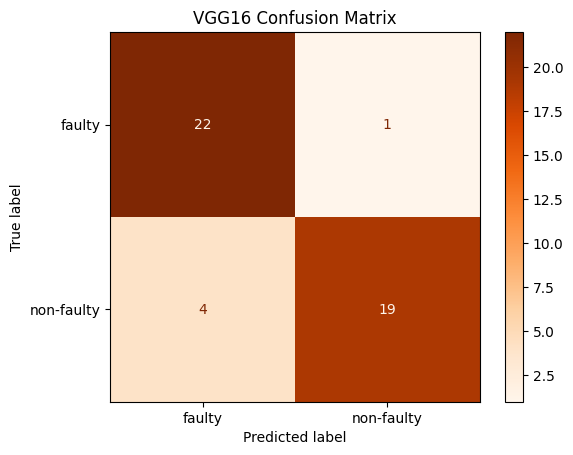

In [14]:
# --- Confusion Matrix ---
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Oranges)
plt.title("VGG16 Confusion Matrix")
plt.savefig("vgg16_confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
model.save('VGG-16_BC_model.h5')  # Save the trained model

In [5]:
detection_vgg16 = load_model("/Users/reamy/Desktop/THESIS/VGG-16_BC/best_VGG16_BC_model.h5")

In [6]:
# Collect all validation images and labels
# Initialize lists to store images and labels
val_gen=val_generator
X_val = []
y_val = []
val_gen.reset()
# Go through all batches
for _ in range(val_gen.samples // val_gen.batch_size + 1):
    try:
        imgs, labels = next(val_gen)
        for img, label in zip(imgs, labels):
            X_val.append(img)
            y_val.append(label)
    except StopIteration:
        break

X_val = np.array(X_val)
y_val = np.array(y_val)

# Class labels
class_labels_detection = ['Faulty', 'Non-Faulty']

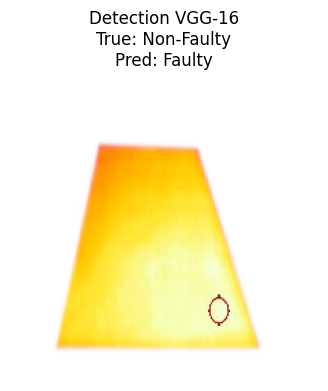

Detection SDCNN Prediction: Faulty
----------------------------------------


In [23]:

class_labels_detection = ['Faulty', 'Non-Faulty']

# Randomly select 5 indices
indices = random.sample(range(len(X_val)), 5)

# Predict and plot
for idx in indices:
    img = X_val[idx]
    label = y_val[idx]

    image_batch = np.expand_dims(img, axis=0)  # Make batch shape (1, 224, 224, 3)

    # Predict using each model
    Detection_VGG16= detection_vgg16.predict(image_batch, verbose=0)[0]
 

    # Convert predictions to labels
    Detection_VGG161 = class_labels_detection[np.argmax(Detection_VGG16)]
   

    # True labels
# True labels
if isinstance(label, (np.ndarray, list)) and len(label) > 1:
    true_label = np.argmax(label)
    true_det_label = class_labels_detection[true_label] if len(label) == 2 else 'N/A'
else:
    true_label = int(label)
    true_det_label = class_labels_detection[true_label]
    true_diag_label = 'N/A'


    # Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detection VGG-16\nTrue: {true_det_label if true_det_label != 'N/A' else true_diag_label}\nPred: {Detection_VGG161}")
    plt.show()

    # Print predictions
    print(f"Detection SDCNN Prediction: {Detection_VGG161}")
   
    print("-" * 40)

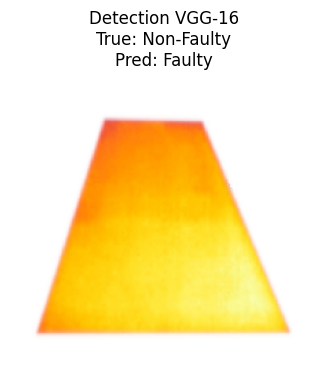

Detection VGG-16 Prediction: Faulty
----------------------------------------


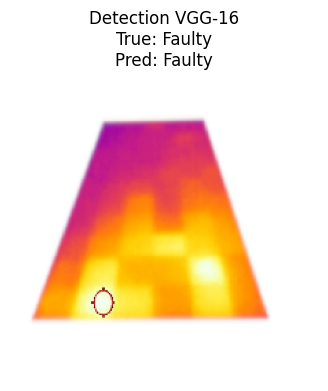

Detection VGG-16 Prediction: Faulty
----------------------------------------


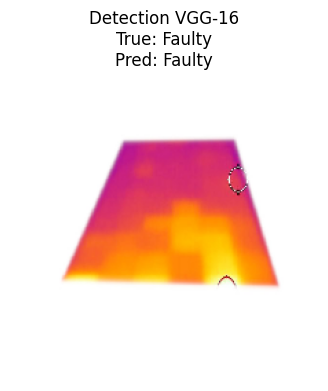

Detection VGG-16 Prediction: Faulty
----------------------------------------


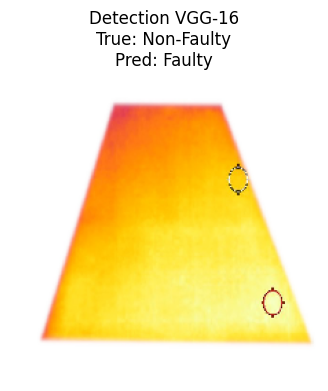

Detection VGG-16 Prediction: Faulty
----------------------------------------


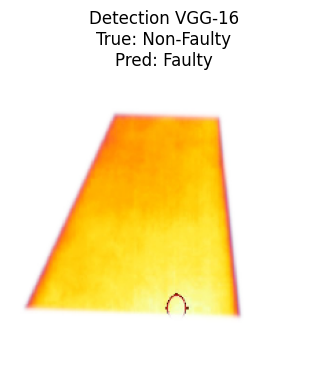

Detection VGG-16 Prediction: Faulty
----------------------------------------


In [24]:

class_labels_detection = ['Faulty', 'Non-Faulty']

# Randomly select 5 indices
indices = random.sample(range(len(X_val)), 5)

for idx in indices:
    img = X_val[idx]
    label = y_val[idx]

    image_batch = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)

    # Predict
    prediction = detection_vgg16.predict(image_batch, verbose=0)[0]
    predicted_class_index = np.argmax(prediction)
    predicted_label = class_labels_detection[predicted_class_index]

    # Determine true label
    if isinstance(label, (np.ndarray, list)) and len(label) > 1:
        true_class_index = np.argmax(label)
    else:
        true_class_index = int(label)
    true_label = class_labels_detection[true_class_index]

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detection VGG-16\nTrue: {true_label}\nPred: {predicted_label}")
    plt.show()

    print(f"Detection VGG-16 Prediction: {predicted_label}")
    print("-" * 40)

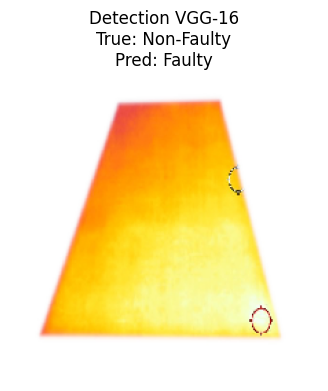

Detection VGG-16 Prediction: Faulty
----------------------------------------


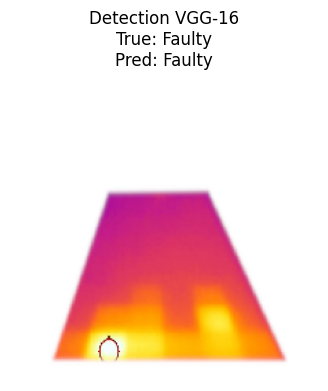

Detection VGG-16 Prediction: Faulty
----------------------------------------


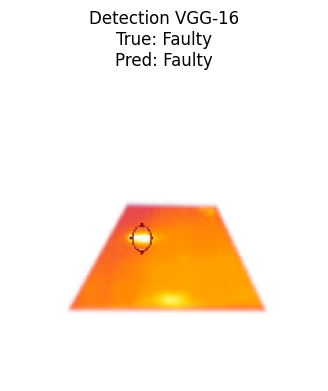

Detection VGG-16 Prediction: Faulty
----------------------------------------


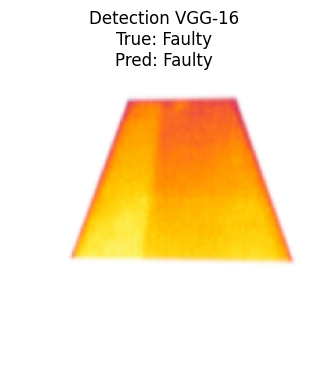

Detection VGG-16 Prediction: Faulty
----------------------------------------


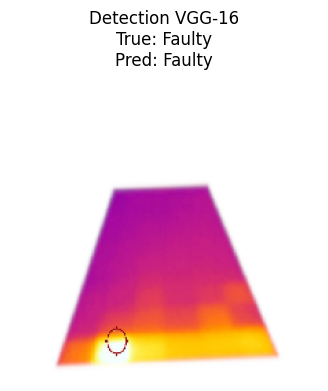

Detection VGG-16 Prediction: Faulty
----------------------------------------


In [25]:

import matplotlib.pyplot as plt

# Ensure correct mapping based on your dataset
class_labels_detection = ['Faulty', 'Non-Faulty']  # Change if needed

# Randomly select 5 indices
indices = random.sample(range(len(X_val)), 5)

for idx in indices:
    img = X_val[idx]
    label = y_val[idx]  # Already an integer (0 or 1)

    image_batch = np.expand_dims(img, axis=0)

    # Get prediction
    prediction = detection_vgg16.predict(image_batch, verbose=0)[0]
    pred_index = np.argmax(prediction)
    pred_label = class_labels_detection[pred_index]

    # Get true label
    true_label = class_labels_detection[int(label)]

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detection VGG-16\nTrue: {true_label}\nPred: {pred_label}")
    plt.show()

    print(f"Detection VGG-16 Prediction: {pred_label}")
    print("-" * 40)